In [11]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score



f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "/Users/esramahmud/Graduation-Project/df_updated_3.csv"
#path = "/Users/esramahmud/IE440/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)




#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)




datetime_column = df.columns[0]  # Adjust this if your datetime column isn't the first one

# Add month and week number columns
df_scaled['number_of_the_month'] = df_scaled[datetime_column].dt.month
df_scaled['number_of_the_week'] = df_scaled[datetime_column].dt.isocalendar().week
df_scaled["number_of_the_day"] = df_scaled[datetime_column].dt.isocalendar().day


df_scaled['number_of_the_month'] = df_scaled['number_of_the_month'].astype('float64')
df_scaled['number_of_the_week'] = (df_scaled['number_of_the_week'].astype('float64') % 4) + 1
df_scaled['number_of_the_day'] = df_scaled['number_of_the_day'].astype('float64')




def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    

    result1 = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")

    probabilities = result1[0]
    y_test = result1[1]

    #probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    #y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    result1 = mpt.get_the_probabilities_with_logistic_regressionn_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)

    probabilities = result1[0]
    y_test = result1[1]

    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(n, f, d, s, l, df, aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount, graph):


    result1 = mpt.get_the_probabilities_with_random_forest_new_new(n, f, d, s, l, df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4, graph)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)

    feature_importances = result1[2]

    return result, feature_importances, y_test


def agg_single_tree(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_single_tree(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result



def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    print(1)
    print(df)

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()


df_back_up = df_scaled.copy()

                     Importance
DV_pressure            0.896048
number_of_the_day      0.070067
Oil_temperature        0.031348
H1                     0.001762
Reservoirs             0.000711
Motor_current          0.000064
number_of_the_month    0.000000
R-squareddd: 0.9953469687325254
F-Value Like: 3066146.7874215967
model preditions
[0 0 0 ... 0 0 0]
model proba
[0.         0.         0.         ... 0.01886792 0.01886792 0.01886792]
        model_predictions  model_probablities
0                       0            0.000000
1                       0            0.000000
2                       0            0.000000
3                       0            0.000000
4                       0            0.000000
...                   ...                 ...
649822                  0            0.018868
649823                  0            0.018868
649824                  0            0.018868
649825                  0            0.018868
649826                  0            0.018868

[649827

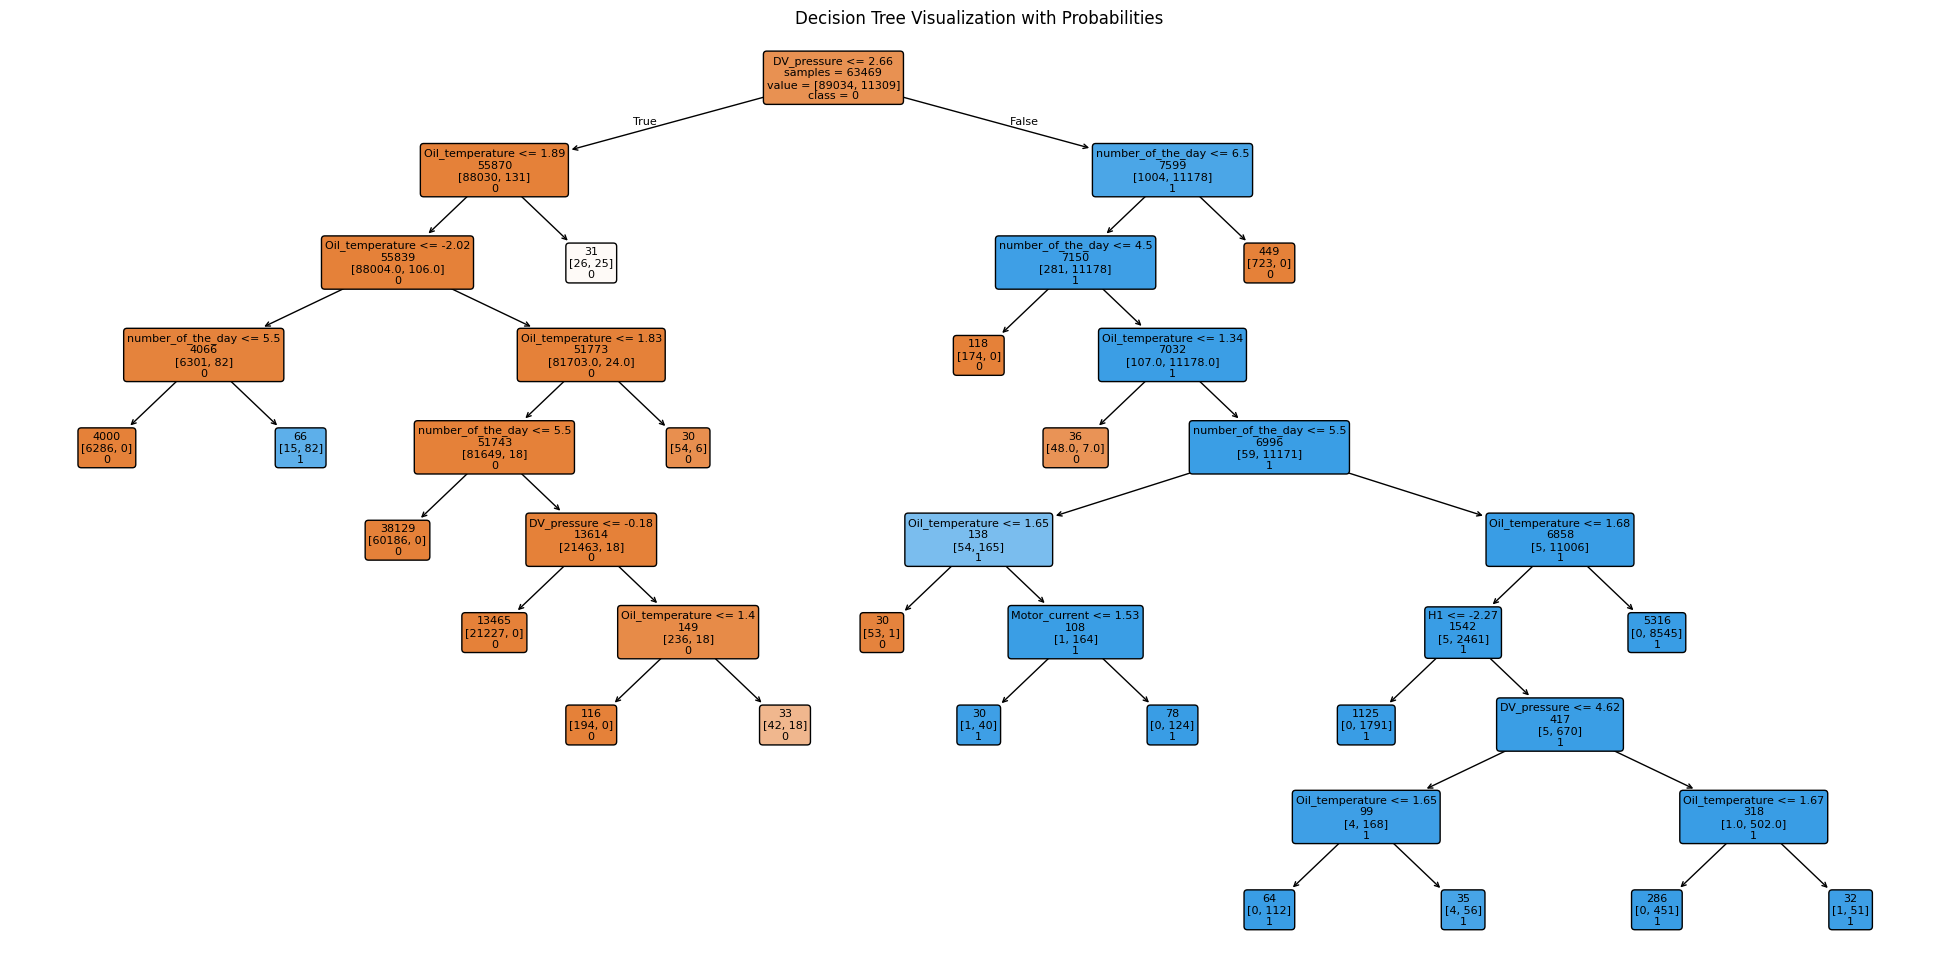

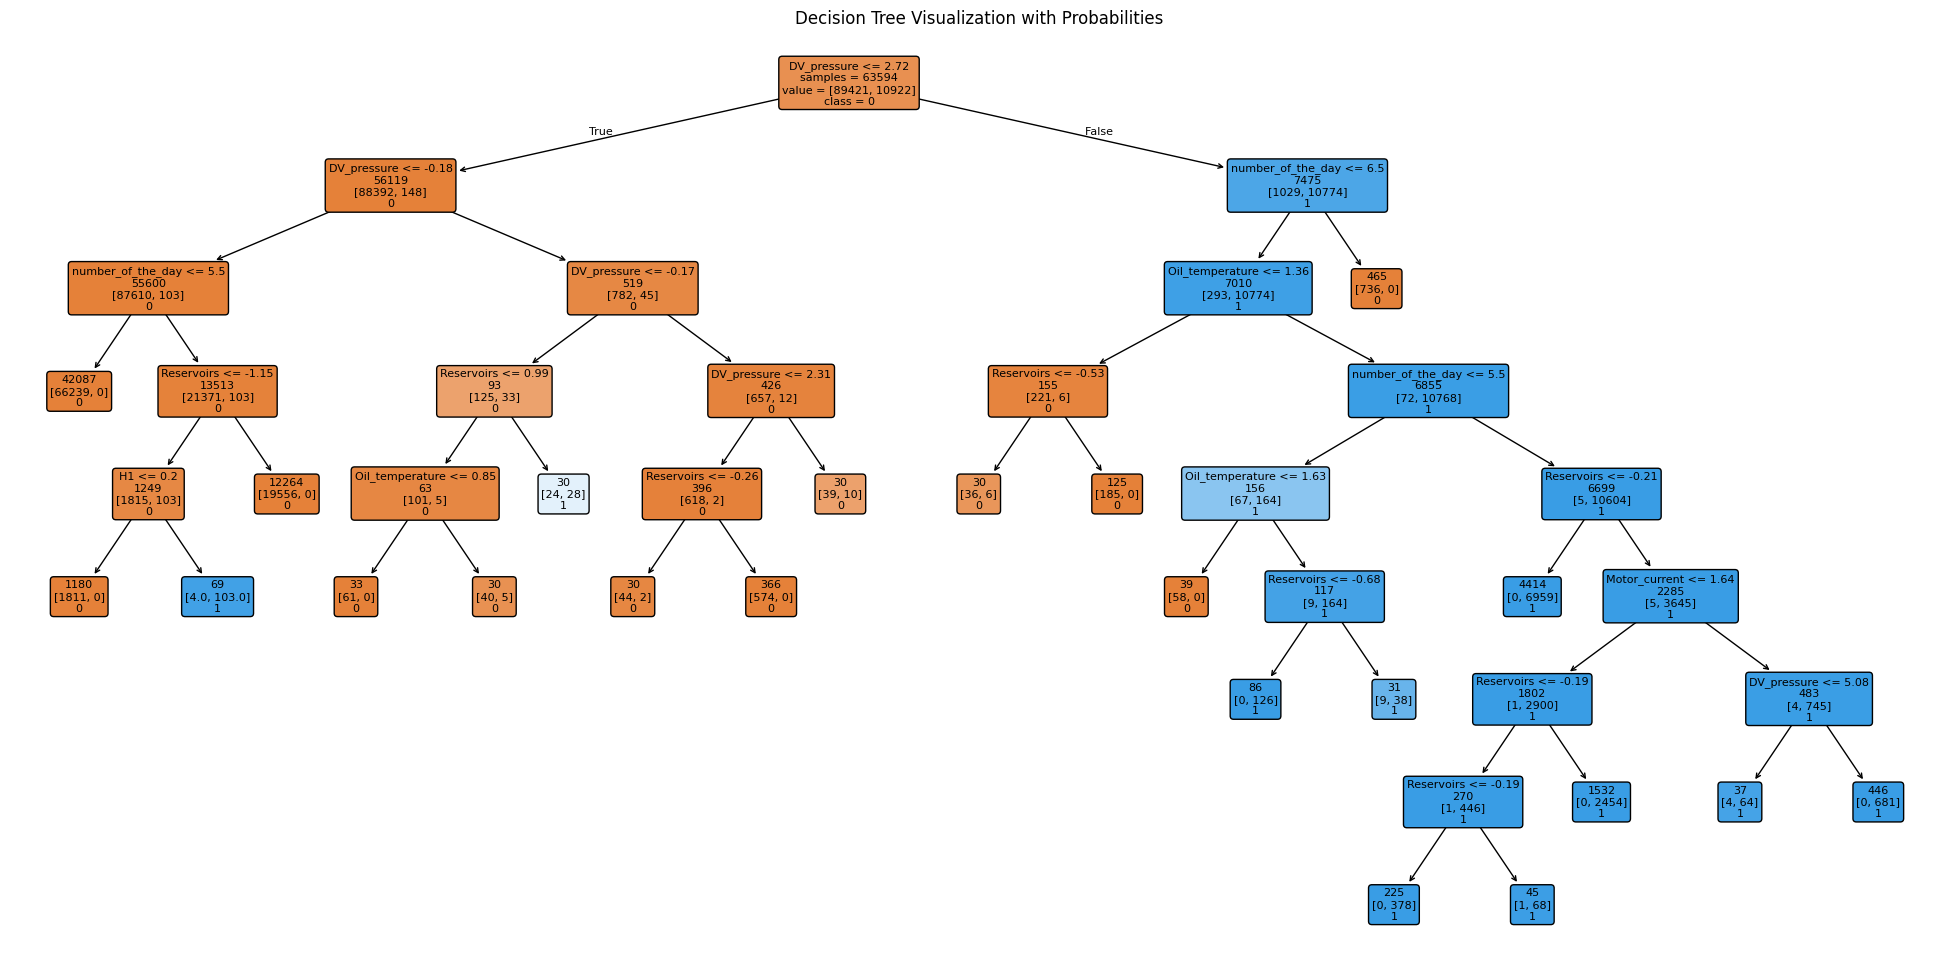

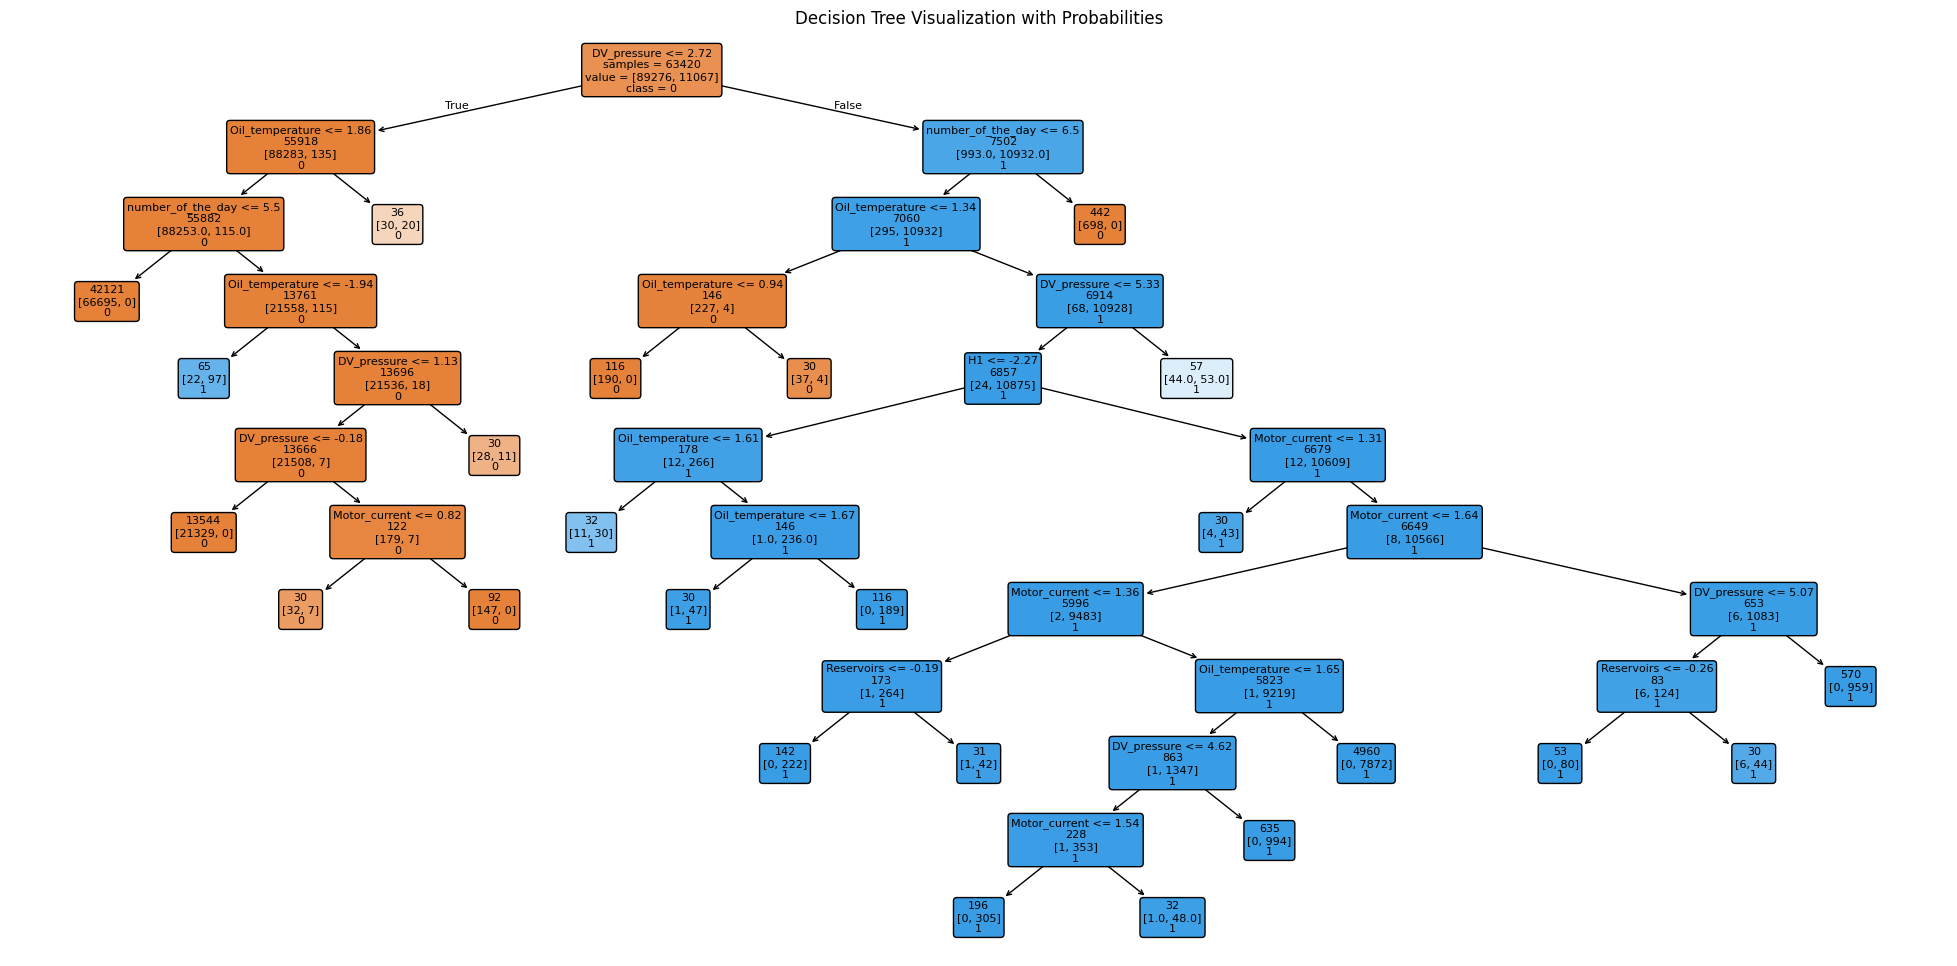

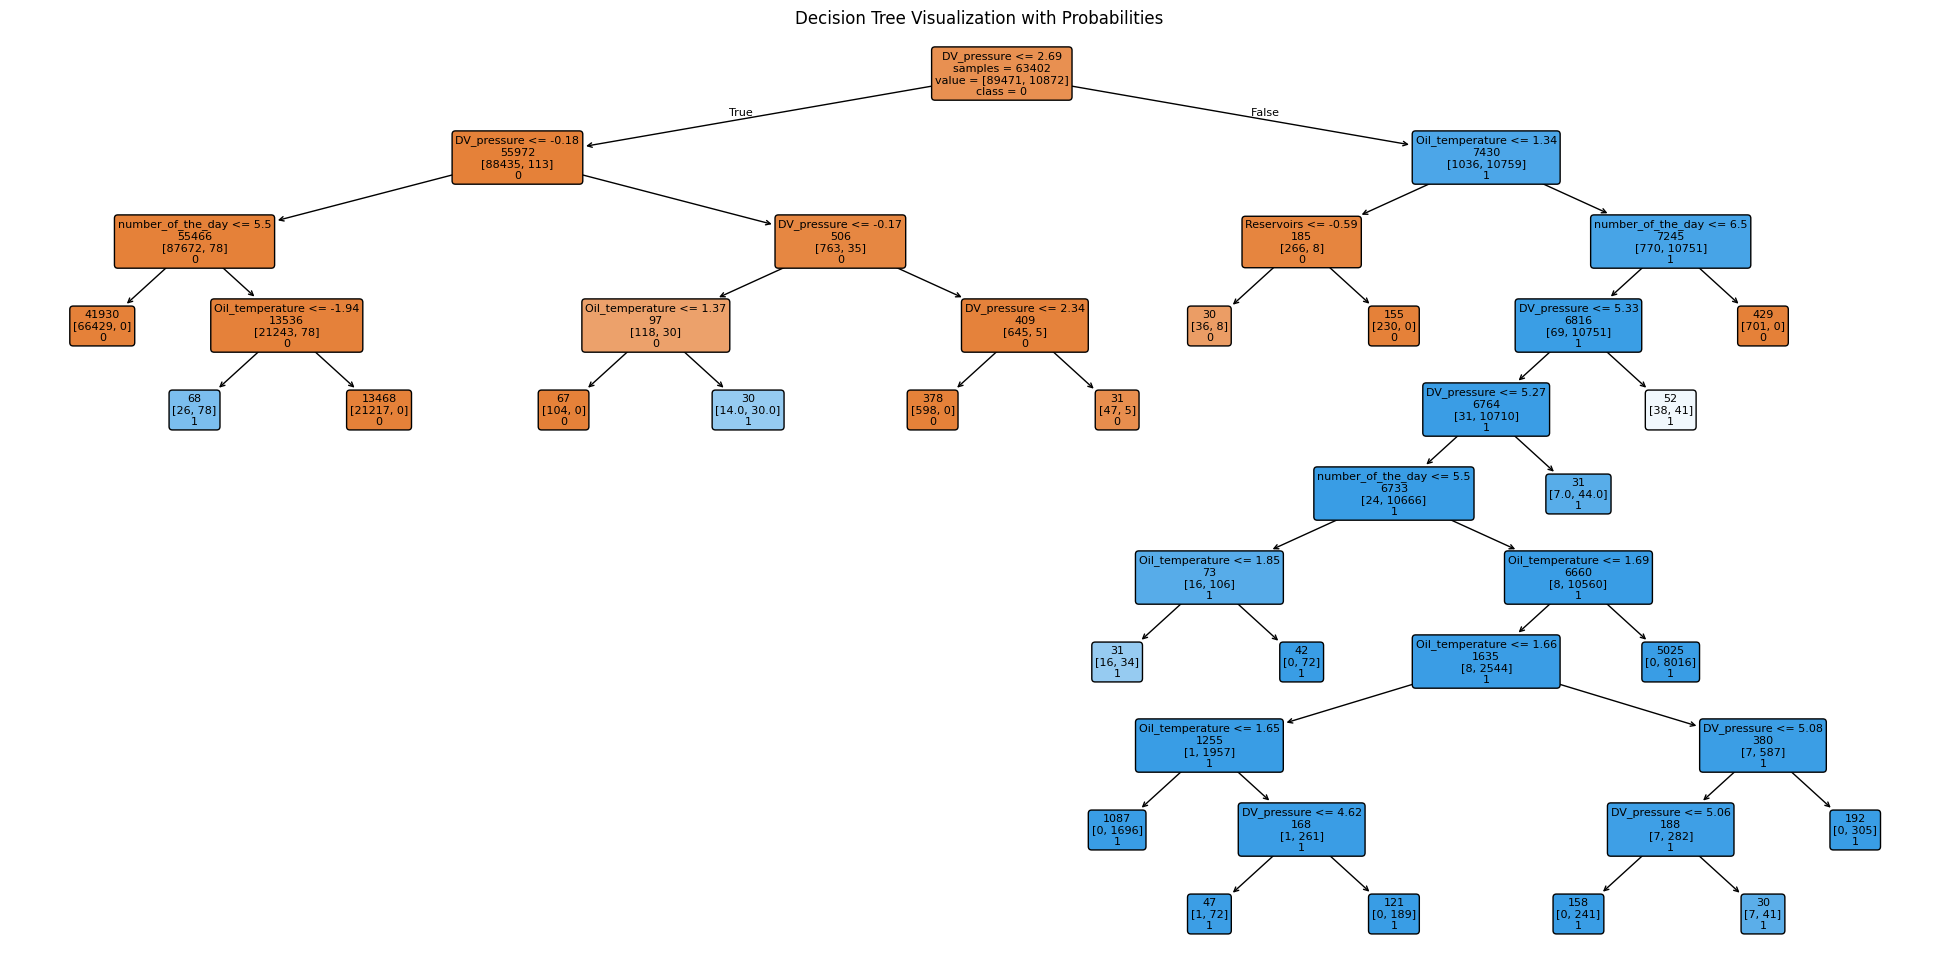

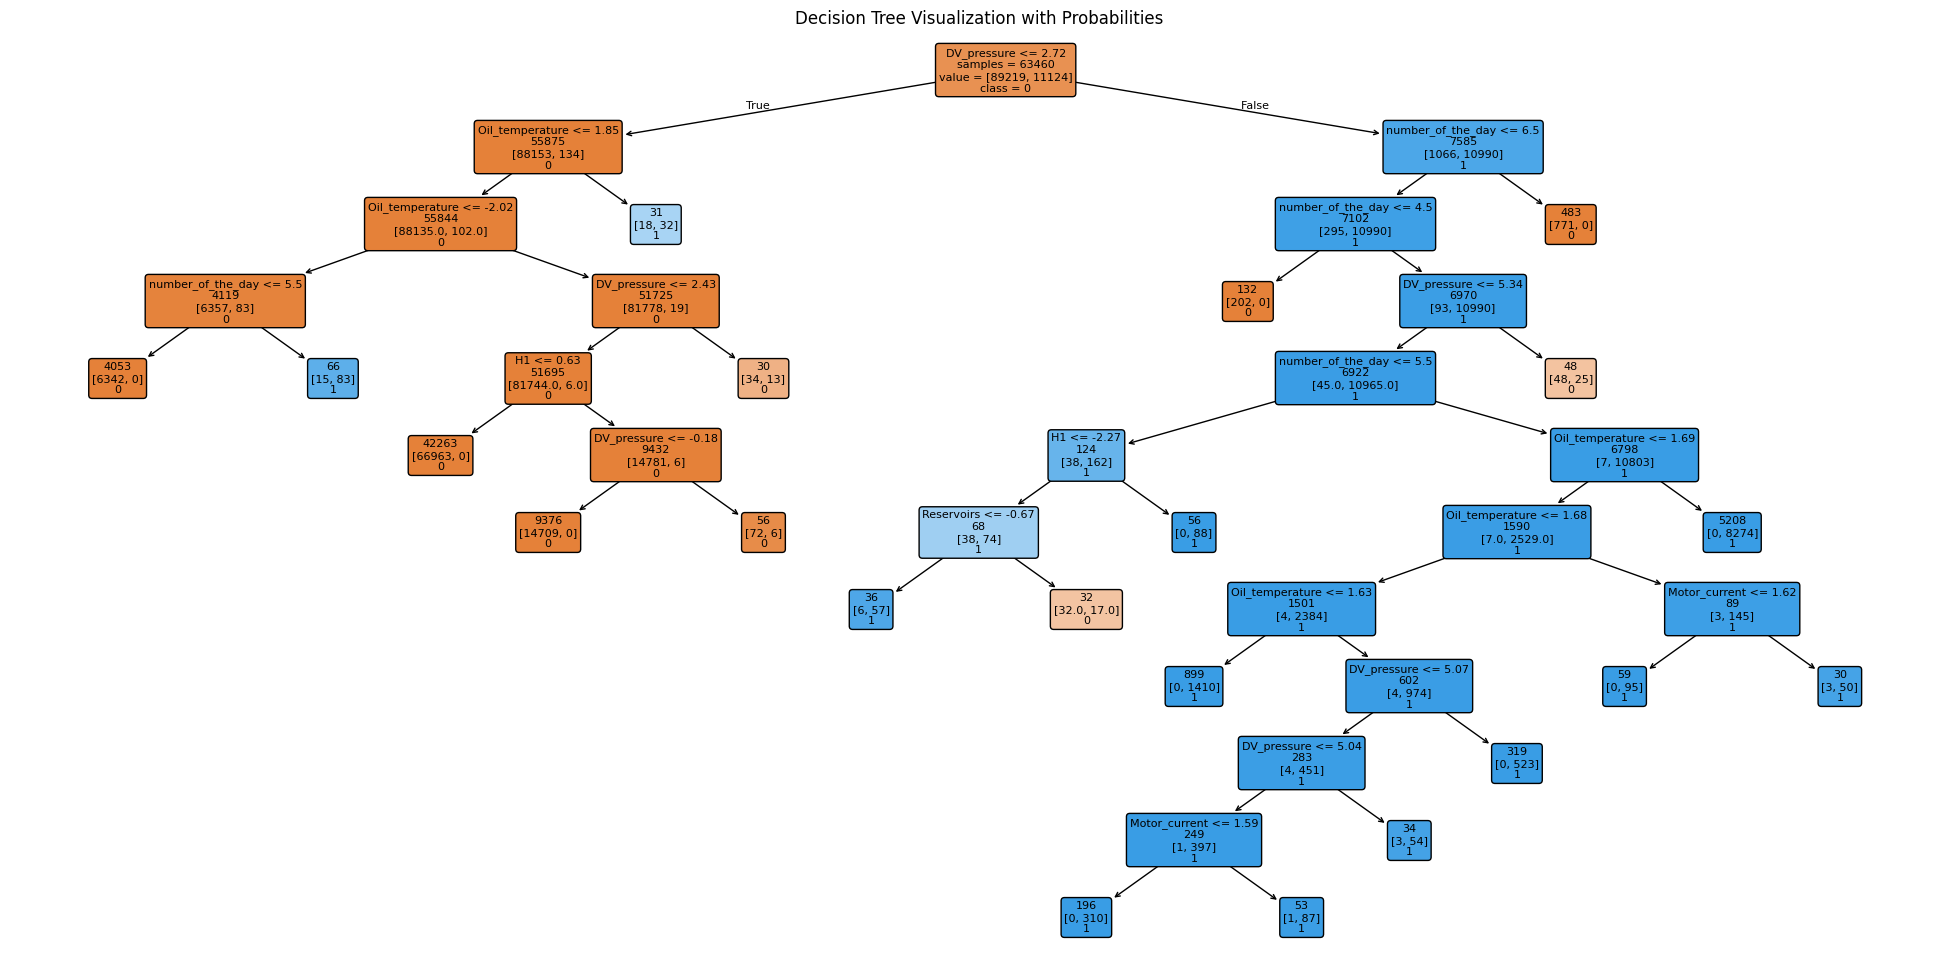

1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000052          0
1            1        100      499        400  0.000052          0
2            2        200      599        400  0.000052          0
3            3        300      699        400  0.000052          0
4            4        400      799        400  0.000000          0
...        ...        ...      ...        ...       ...        ...
6491      6491     649100   649499        400  0.064462          0
6492      6492     649200   649599        400  0.069570          0
6493      6493     649300   649699        400  0.168560          0
6494      6494     649400   649799        400  0.306421          0
6495      6495     649500   649826        327  0.360960          0

[6496 rows x 6 columns]


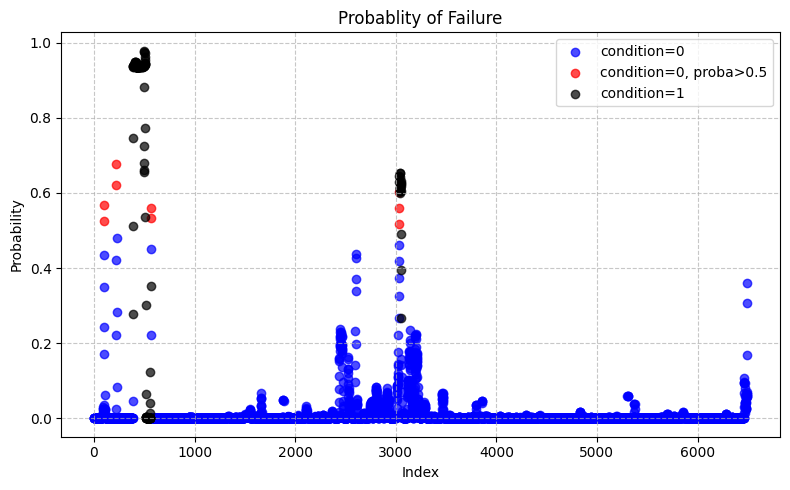

In [12]:
dataframe = df_back_up.copy()


dataframe = dataframe.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)



def fit_the_model(i, j, k, l):
    
    aggregation_size = 400

    treshold_probability = 0.5

    aggregated_probabilities, f1, a = agg_random_forest(i, 5, j, k, l, dataframe, aggregation_size, 4, 2, 4, 2, 5, 18, 18, 50, "yes", "yes", "no", "no", 100, "yes")

    plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)


fit_the_model(5, 15, 60, 30)

                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[0.00015672 0.00015672 0.00015672 ... 0.         0.         0.        ]
        model_predictions  model_probablities
0                       0            0.000157
1                       0            0.000157
2                       0            0.000157
3                       0            0.000157
4                       0            0.000157
...                   ...                 ...
649822                  0            0.000000
649823                  0            0.000000
649824                  0            0.000000
649825                  0            0.000000
649826                  0            0.000000

[649827 

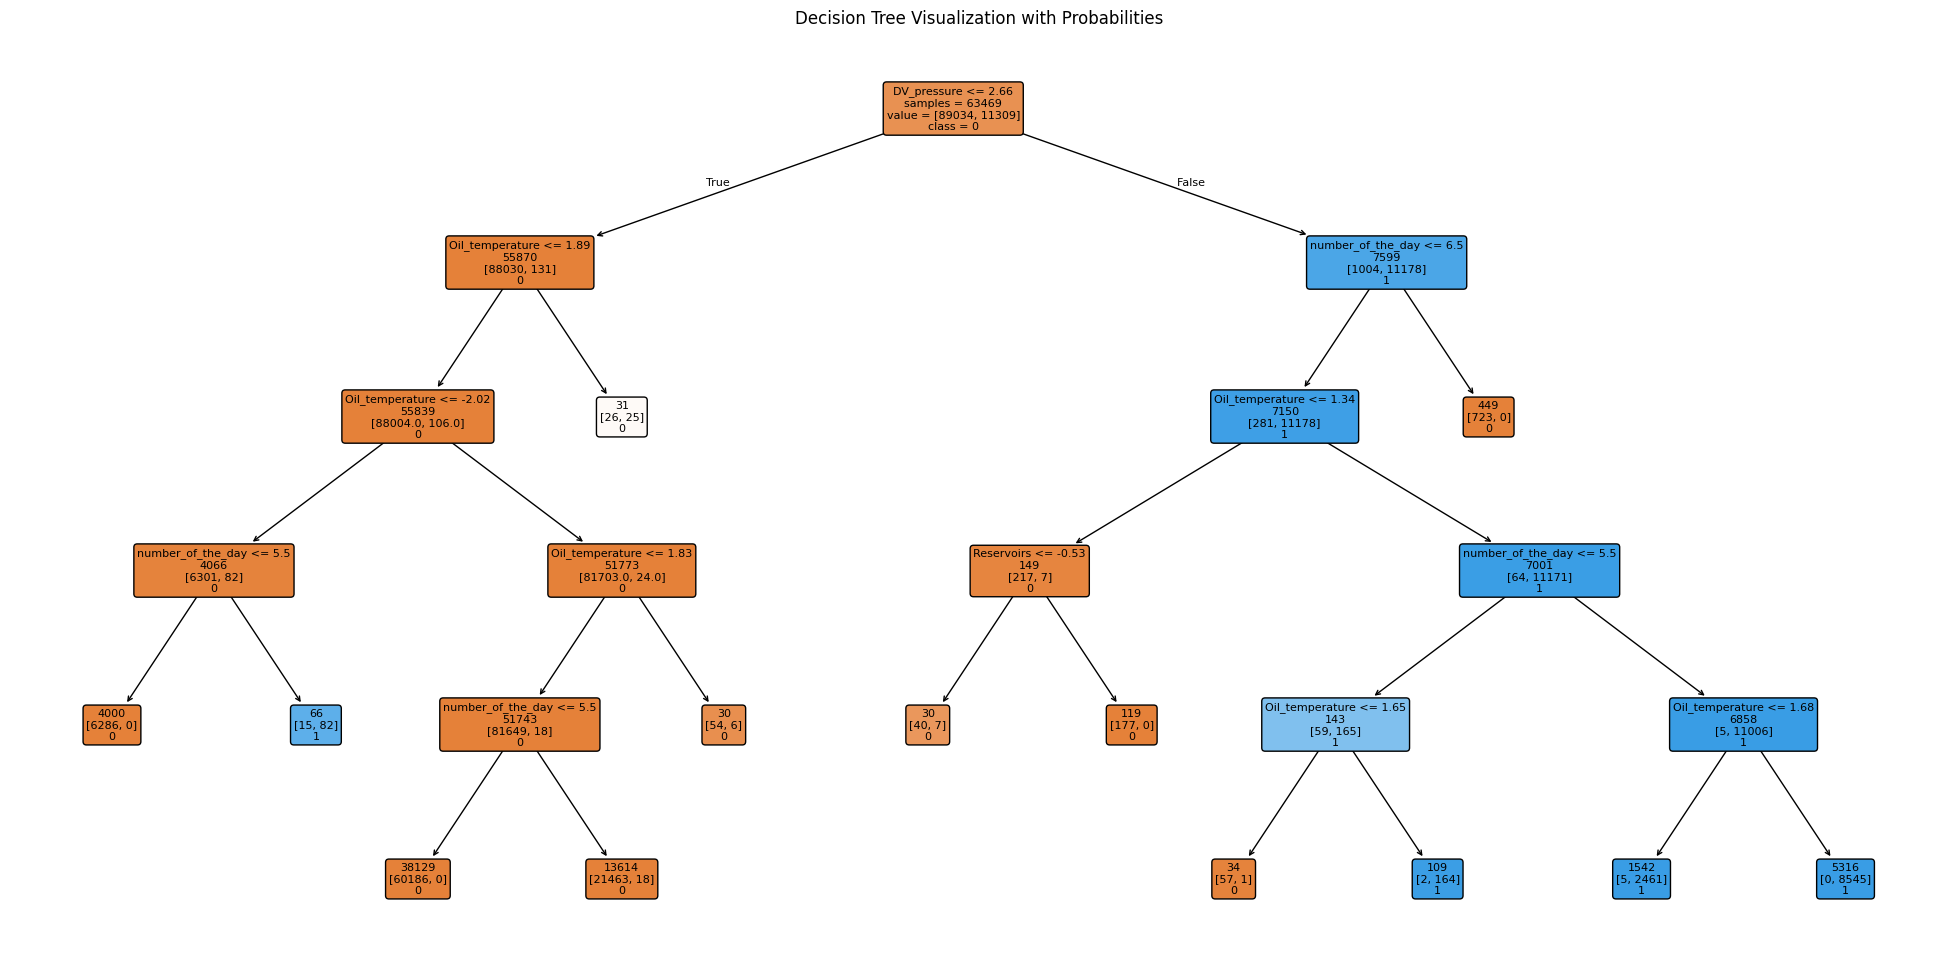

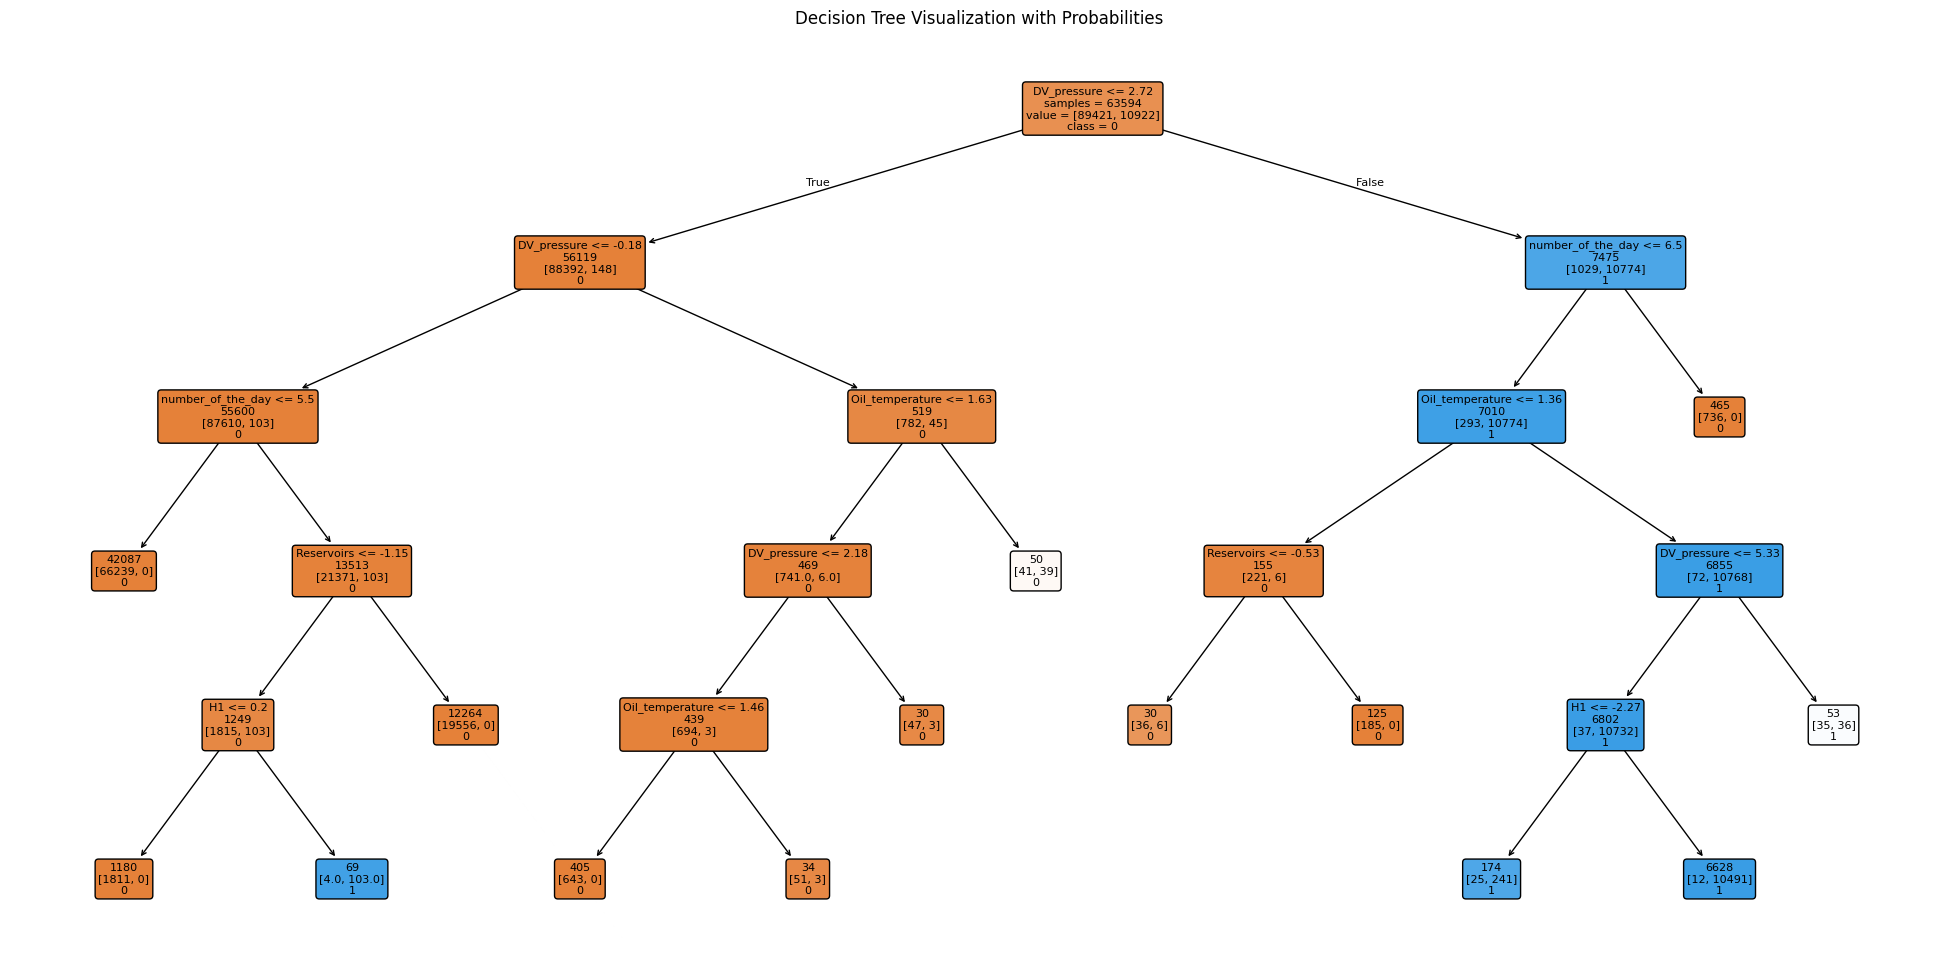

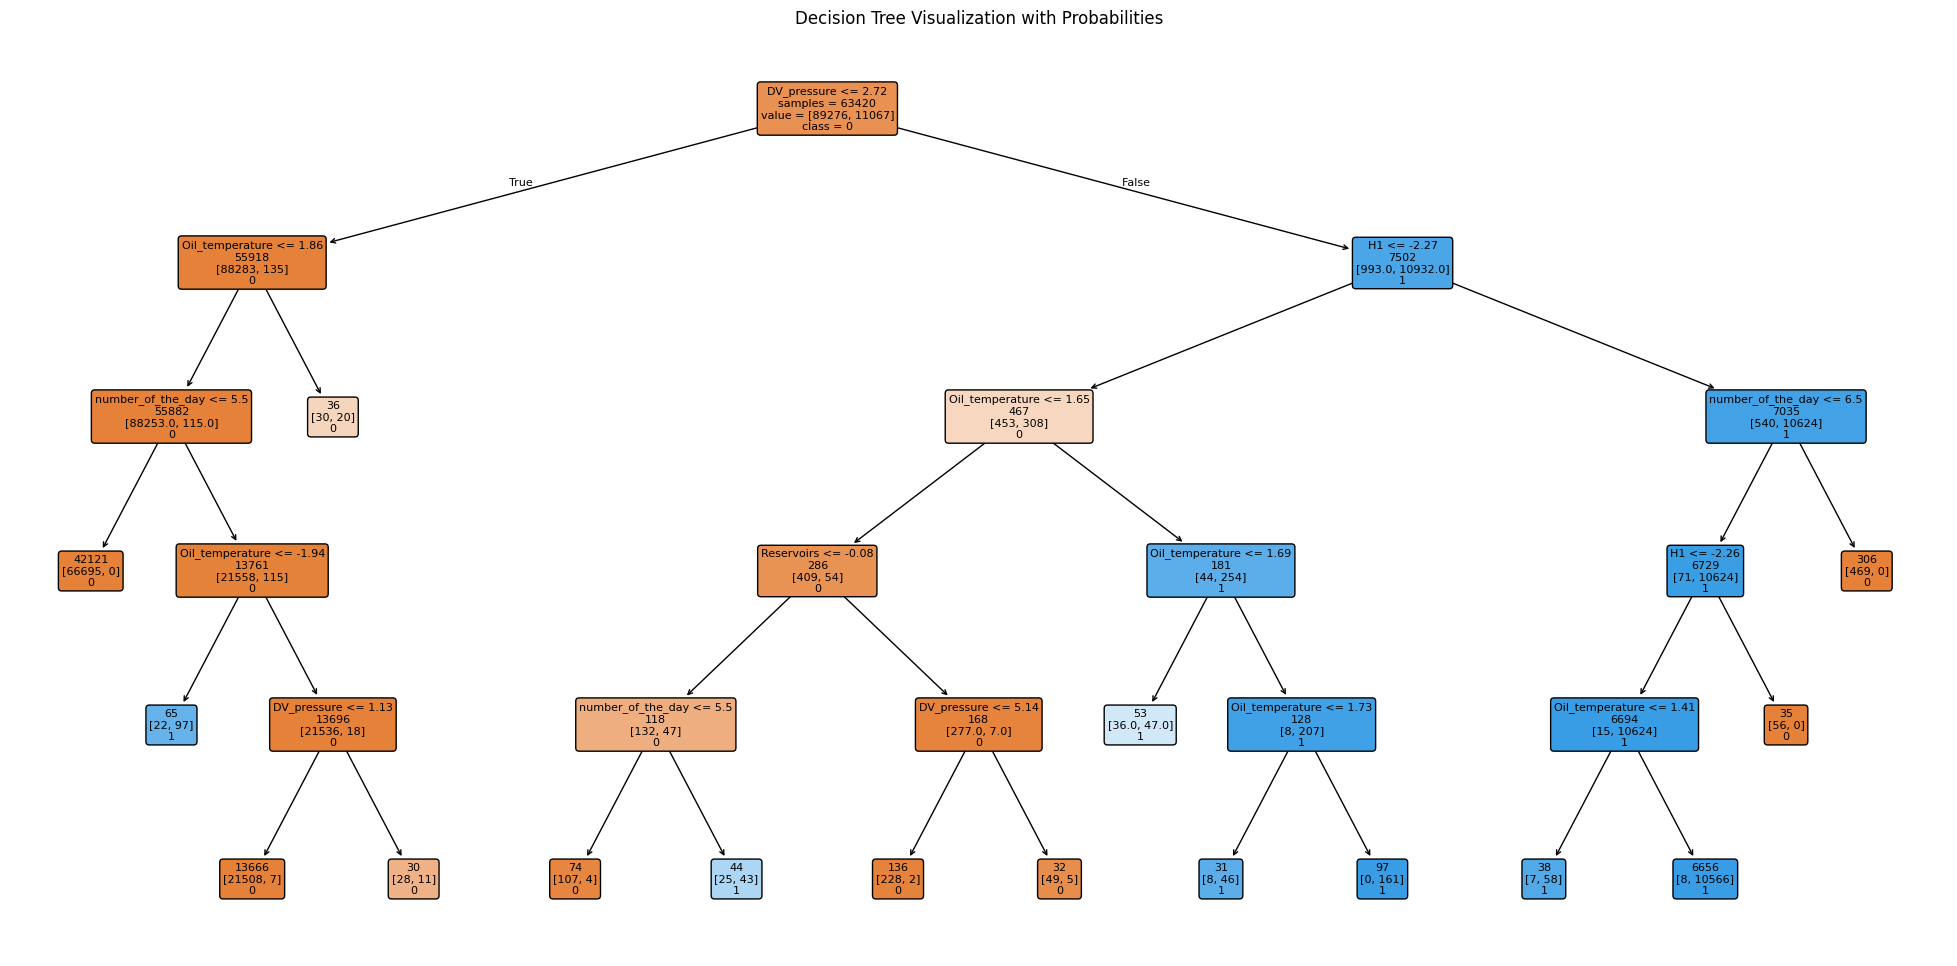

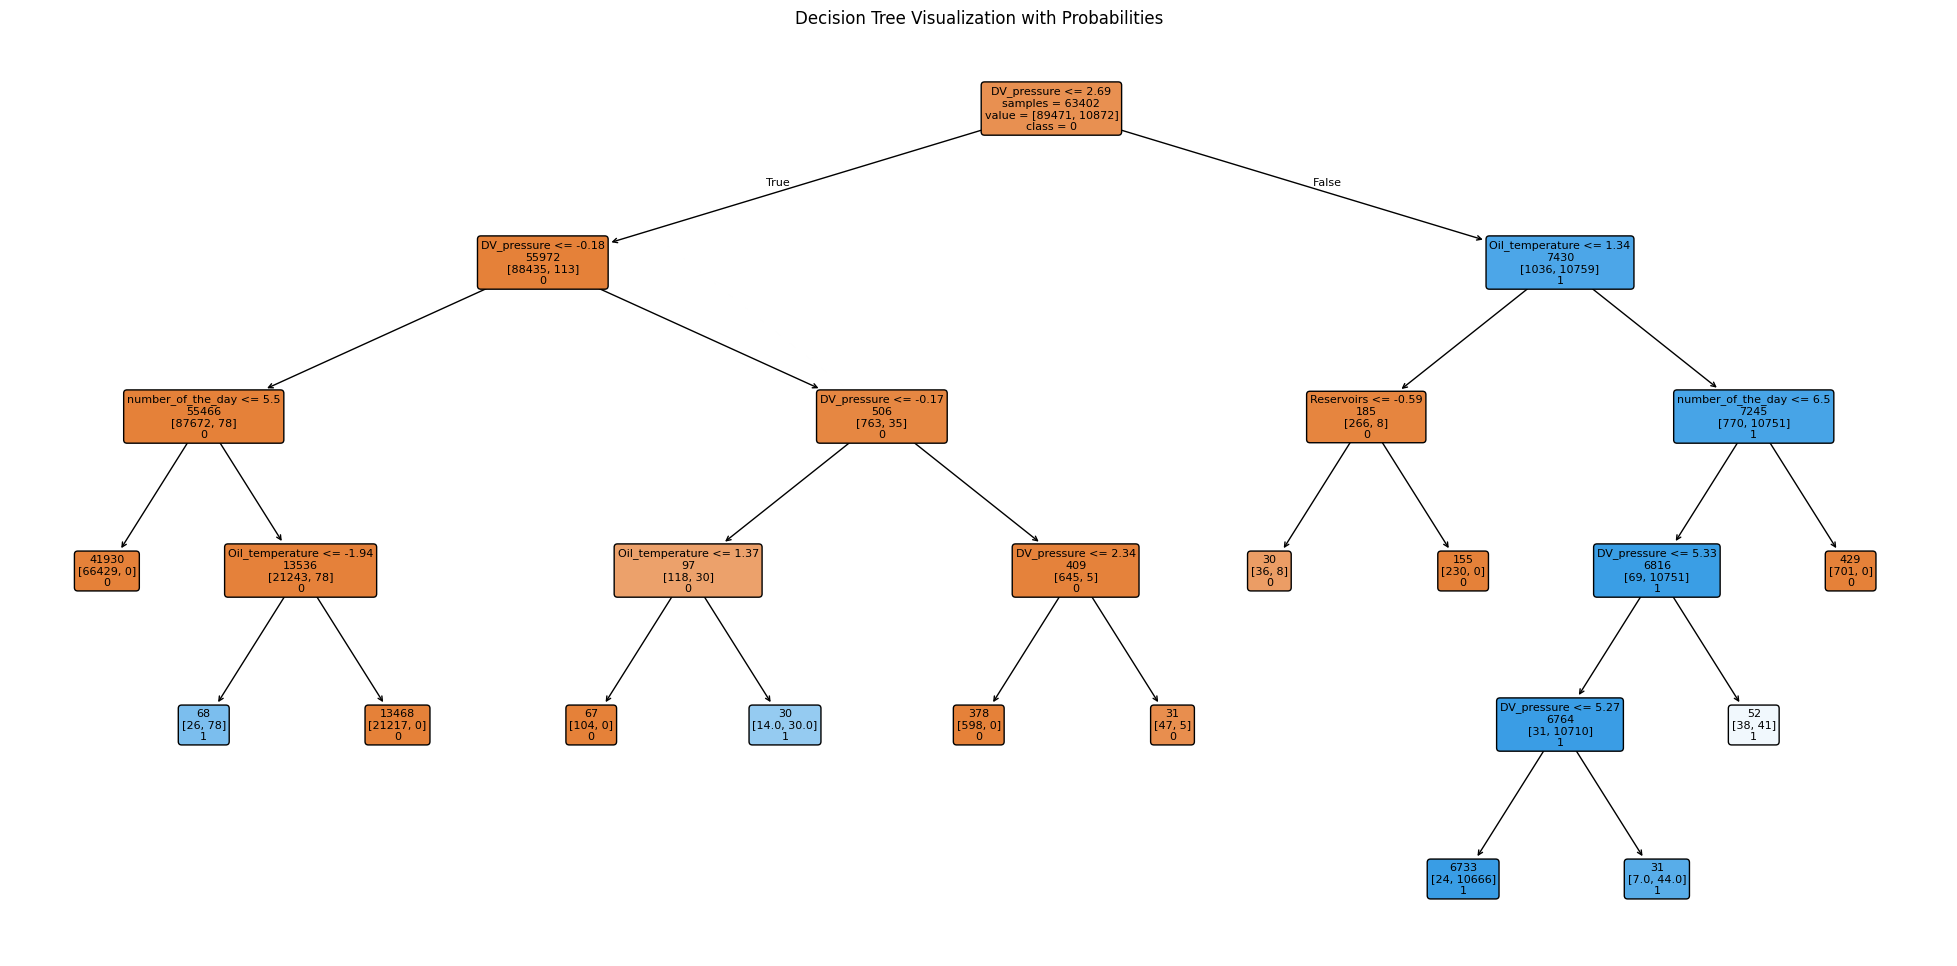

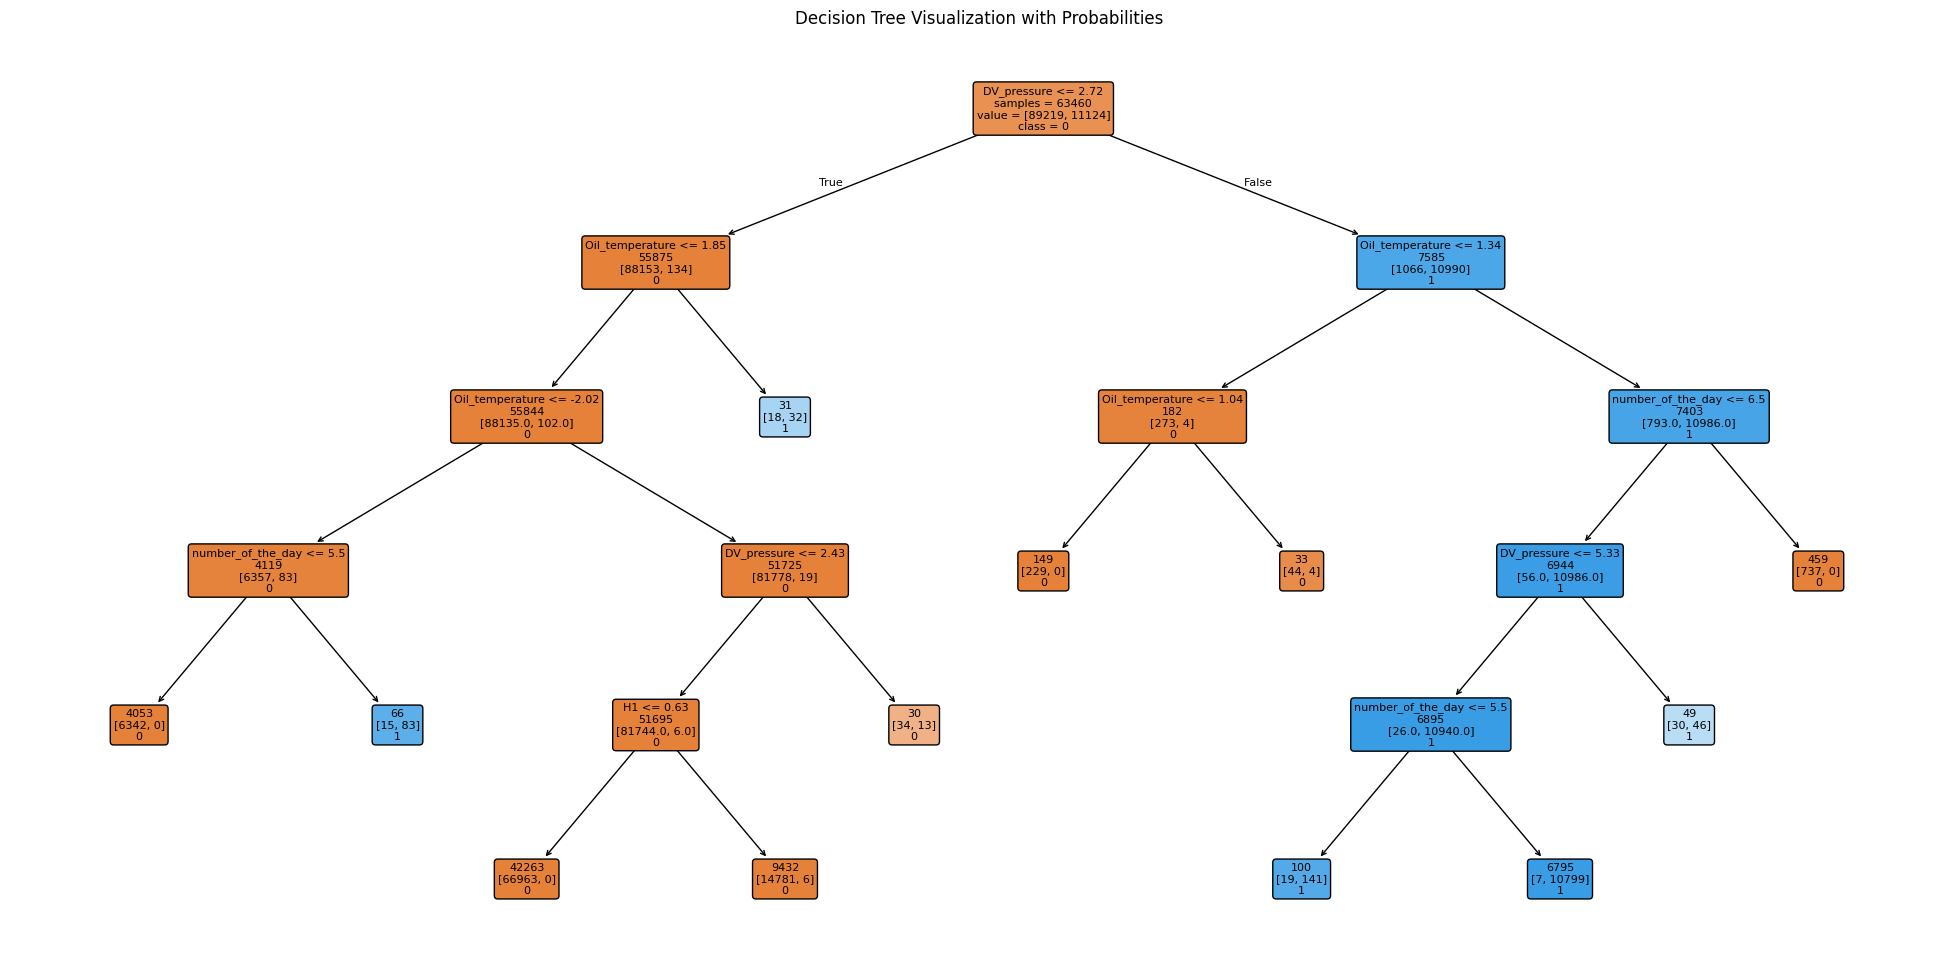

1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000232          0
1            1        100      499        400  0.000236          0
2            2        200      599        400  0.000239          0
3            3        300      699        400  0.000240          0
4            4        400      799        400  0.000185          0
...        ...        ...      ...        ...       ...        ...
6491      6491     649100   649499        400  0.049814          0
6492      6492     649200   649599        400  0.060166          0
6493      6493     649300   649699        400  0.146625          0
6494      6494     649400   649799        400  0.257834          0
6495      6495     649500   649826        327  0.303667          0

[6496 rows x 6 columns]


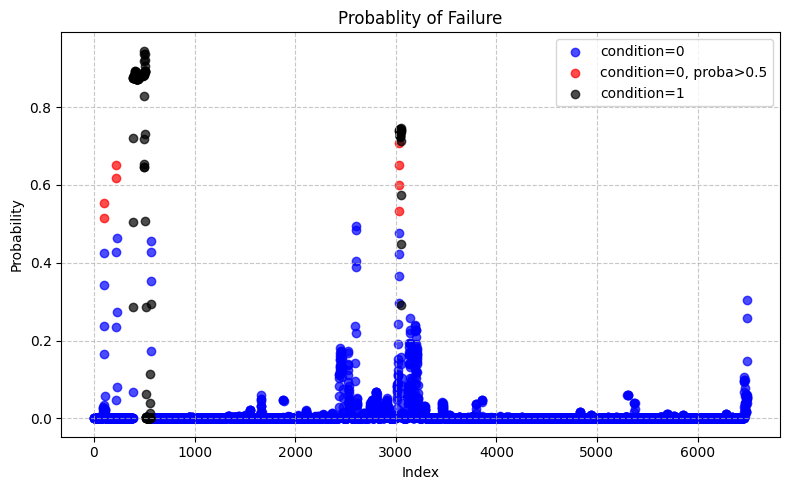

In [13]:
dataframe = df_back_up.copy()


dataframe = dataframe.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)



def fit_the_model(i, j, k, l):
    
    aggregation_size = 400

    treshold_probability = 0.5

    aggregated_probabilities, f1, a = agg_random_forest(i, 5, j, k, l, dataframe, aggregation_size, 4, 2, 4, 2, 5, 18, 18, 70, "yes", "yes", "no", "no", 100, "yes")

    plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)


fit_the_model(5, 5, 60, 30)